Transfer Learning with Model: EfficientNet B0

In [156]:
import torch
import torchvision
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

0. Setup Train and Test Paths

In [157]:
from pathlib import Path
data_path = Path("data/")

train_dir = data_path / "train"
test_dir = data_path / "test"

train_dir, test_dir

(WindowsPath('data/train'), WindowsPath('data/test'))

1. Convert images to tensors using ImageFolder (Automatic Transformation)

In [162]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [163]:
# Get the transforms used to create pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [164]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = auto_transforms)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = auto_transforms)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 360
     Root location: data\train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 Dataset ImageFolder
     Number of datapoints: 80
     Root location: data\test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ))

In [165]:
class_names = train_data.classes
class_names

['black', 'blue', 'green', 'red']

2. Prepare dataloader

In [166]:
from torch.utils.data import DataLoader
import os

number = os.cpu_count() 
train_dataloader = DataLoader(dataset = train_data,        
                              batch_size = 32,
                              num_workers = number,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = 32,
                              num_workers = number,
                              shuffle = False)

3. Get pretrained Model (EfficientNet B0)

In [167]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Freeze base model and change output layer to suit our needs

In [168]:
for param in model.features.parameters():
    param.requires_grad = False

In [169]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

# Recreate the classifier layer 
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, 
                    bias=True)).to(device)

Summary of Model

In [170]:
from torchinfo import summary
summary(model, input_size=[1, 3, 224, 224]) # [batch size, colour channels, height, width]

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 4]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         (864)
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         (64)
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         (1,448)
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           (6,004)
│    │    └─MBConv: 3-6                      

In [171]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [172]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [173]:
from tqdm.auto import tqdm

epochs = 15

results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []
           }

for i in tqdm(range(epochs)):
    print("Epoch: ", i)

    # training
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X_train, y_train) in enumerate(train_dataloader): # use this for per batch
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_pred = model(X_train)
        tr_loss = loss_func(y_pred, y_train)
        train_loss += tr_loss.item()
        train_acc += accuracy_fn(y_train, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        tr_loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # testing
    test_loss, test_acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            test_pred = model(X_test)
            te_loss = loss_func(test_pred, y_test)
            test_loss += te_loss.item()
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"\nTrain loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%\n")
    print(f"\nTest loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:  0


  7%|▋         | 1/15 [00:20<04:46, 20.47s/it]


Train loss: 1.18898, Train acc: 58.59%


Test loss: 1.09641, Test acc: 66.67%

Epoch:  1


 13%|█▎        | 2/15 [00:40<04:25, 20.42s/it]


Train loss: 0.75822, Train acc: 94.53%


Test loss: 0.76767, Test acc: 79.17%

Epoch:  2


 20%|██        | 3/15 [01:01<04:04, 20.36s/it]


Train loss: 0.52006, Train acc: 96.61%


Test loss: 0.62332, Test acc: 83.33%

Epoch:  3


 27%|██▋       | 4/15 [01:19<03:35, 19.56s/it]


Train loss: 0.41187, Train acc: 98.44%


Test loss: 0.53954, Test acc: 86.46%

Epoch:  4


 33%|███▎      | 5/15 [01:38<03:12, 19.29s/it]


Train loss: 0.29391, Train acc: 98.70%


Test loss: 0.47350, Test acc: 86.46%

Epoch:  5


 40%|████      | 6/15 [01:57<02:53, 19.30s/it]


Train loss: 0.26445, Train acc: 98.44%


Test loss: 0.44303, Test acc: 86.46%

Epoch:  6


 47%|████▋     | 7/15 [02:18<02:38, 19.84s/it]


Train loss: 0.24997, Train acc: 98.70%


Test loss: 0.43944, Test acc: 84.38%

Epoch:  7


 53%|█████▎    | 8/15 [02:39<02:20, 20.14s/it]


Train loss: 0.19329, Train acc: 99.48%


Test loss: 0.40479, Test acc: 86.46%

Epoch:  8


 60%|██████    | 9/15 [02:59<02:01, 20.26s/it]


Train loss: 0.18297, Train acc: 98.70%


Test loss: 0.38918, Test acc: 88.54%

Epoch:  9


 67%|██████▋   | 10/15 [03:22<01:44, 20.95s/it]


Train loss: 0.15241, Train acc: 98.70%


Test loss: 0.35419, Test acc: 88.54%

Epoch:  10


 73%|███████▎  | 11/15 [03:41<01:21, 20.38s/it]


Train loss: 0.13975, Train acc: 99.74%


Test loss: 0.37040, Test acc: 87.50%

Epoch:  11


 80%|████████  | 12/15 [04:02<01:01, 20.65s/it]


Train loss: 0.15905, Train acc: 98.18%


Test loss: 0.37829, Test acc: 86.46%

Epoch:  12


 87%|████████▋ | 13/15 [04:24<00:41, 20.99s/it]


Train loss: 0.11847, Train acc: 98.18%


Test loss: 0.33215, Test acc: 88.54%

Epoch:  13


 93%|█████████▎| 14/15 [04:44<00:20, 20.66s/it]


Train loss: 0.10311, Train acc: 99.74%


Test loss: 0.32176, Test acc: 89.58%

Epoch:  14


100%|██████████| 15/15 [05:04<00:00, 20.30s/it]


Train loss: 0.09024, Train acc: 100.00%


Test loss: 0.33912, Test acc: 89.58%



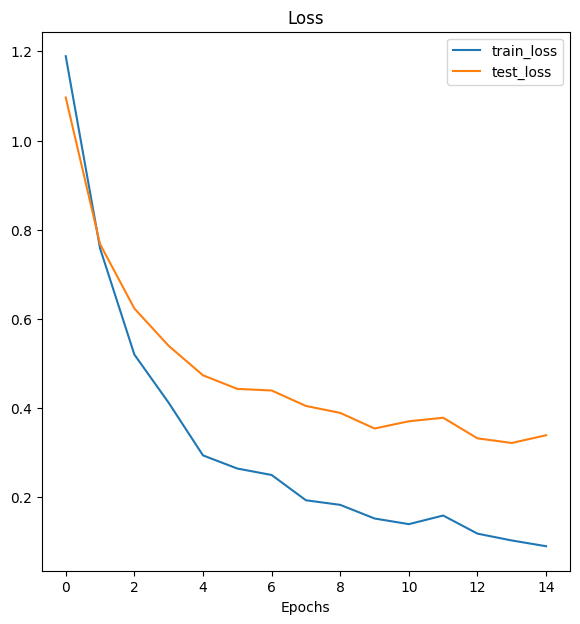

In [174]:
import matplotlib.pyplot as plt

# Get the loss values of the results dictionary (training and test)
train_loss = results['train_loss']
test_loss = results['test_loss']

# Get the accuracy values of the results dictionary (training and test)
# accuracy = results['train_acc']
# test_accuracy = results['test_acc']

# Figure out how many epochs there were
epochs = range(len(results['train_loss']))

plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='train_loss')
plt.plot(epochs, test_loss, label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

4. Test model with custom image

In [193]:
import torchvision
custom_image_path = "data/xd.jpg"
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8, custom_image_uint8.shape, custom_image_uint8.dtype      # need to change values to range of 0-1 and 3, 64, 64 and float32

(tensor([[[115, 115, 115,  ..., 108, 112, 115],
          [118, 118, 118,  ..., 106, 111, 115],
          [115, 115, 115,  ..., 105, 112, 117],
          ...,
          [ 64,  64,  64,  ..., 127, 117, 108],
          [ 71,  70,  70,  ...,  80,  83,  82],
          [ 64,  64,  64,  ...,  79,  85,  82]],
 
         [[112, 112, 112,  ..., 104, 108, 111],
          [115, 115, 115,  ..., 102, 107, 111],
          [112, 112, 112,  ..., 101, 108, 113],
          ...,
          [ 52,  52,  52,  ...,  95,  85,  76],
          [ 59,  58,  58,  ...,  50,  53,  52],
          [ 52,  52,  52,  ...,  49,  55,  52]],
 
         [[131, 131, 131,  ..., 121, 125, 128],
          [134, 134, 134,  ..., 119, 124, 128],
          [129, 129, 129,  ..., 118, 125, 130],
          ...,
          [ 64,  64,  64,  ..., 108,  98,  89],
          [ 71,  70,  70,  ...,  62,  65,  64],
          [ 64,  64,  64,  ...,  61,  67,  64]]], dtype=torch.uint8),
 torch.Size([3, 1046, 591]),
 torch.uint8)

In [194]:
from torchvision import transforms

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255      # change to float32 and values range of 0-1

custom_image_transform = transforms.Compose([
    transforms.Resize(size = (224,224))
])

custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed, custom_image_transformed.shape, custom_image_transformed.dtype

(tensor([[[0.4581, 0.4581, 0.4584,  ..., 0.4198, 0.4149, 0.4395],
          [0.4660, 0.4660, 0.4661,  ..., 0.4308, 0.4298, 0.4592],
          [0.4747, 0.4747, 0.4747,  ..., 0.4416, 0.4444, 0.4802],
          ...,
          [0.2591, 0.2413, 0.2503,  ..., 0.2344, 0.2227, 0.2119],
          [0.2571, 0.2536, 0.2575,  ..., 0.4916, 0.4563, 0.4149],
          [0.2602, 0.2583, 0.2601,  ..., 0.4001, 0.4325, 0.4299]],
 
         [[0.4465, 0.4465, 0.4468,  ..., 0.4041, 0.3989, 0.4235],
          [0.4570, 0.4570, 0.4570,  ..., 0.4121, 0.4063, 0.4348],
          [0.4669, 0.4669, 0.4669,  ..., 0.4141, 0.4114, 0.4441],
          ...,
          [0.2120, 0.1942, 0.2032,  ..., 0.1389, 0.1272, 0.1164],
          [0.2100, 0.2065, 0.2105,  ..., 0.3806, 0.3453, 0.3039],
          [0.2131, 0.2112, 0.2131,  ..., 0.2767, 0.3091, 0.3065]],
 
         [[0.5156, 0.5156, 0.5159,  ..., 0.4707, 0.4657, 0.4903],
          [0.5153, 0.5153, 0.5153,  ..., 0.4798, 0.4756, 0.5045],
          [0.5187, 0.5187, 0.5187,  ...,

In [195]:
model.eval()
with torch.inference_mode():
    custom_image_pred = model(custom_image_transformed.unsqueeze(0).to(device))    # to ensure same device and batch size format of (1, 3 , 224, 224)

custom_image_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_label = torch.argmax(custom_image_probs, dim=1)
custom_image_probs, custom_image_label

(tensor([[0.0627, 0.6759, 0.0876, 0.1738]], device='cuda:0'),
 tensor([1], device='cuda:0'))

In [196]:
custom_image_probs.max()     # highest probability

tensor(0.6759, device='cuda:0')

In [197]:
colour = class_names[custom_image_label]    # class of the corresponding probability
colour

'blue'

Image Shape:  torch.Size([224, 224, 3])


(-0.5, 223.5, 223.5, -0.5)

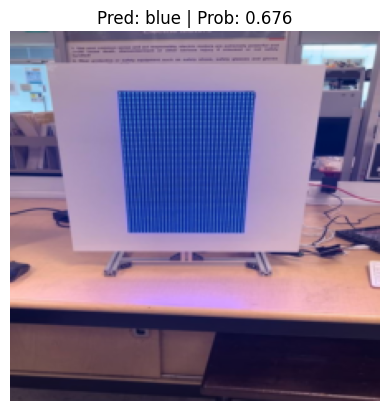

In [198]:
custom_image_transformed_permute = custom_image_transformed.permute(1, 2, 0)   # matplot only works in format of height, width, colour channels

print("Image Shape: ",custom_image_transformed_permute.shape)  # height, width, colour channels
plt.imshow(custom_image_transformed_permute)

title = f"Pred: {colour} | Prob: {custom_image_probs.max().cpu():.3f}"
plt.title(title)
plt.axis(False)